# Analyzing the final iRT values in the human phosphopedia

In [1]:
from util.containers import *

import sqlite3
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
import seaborn as sns

## Intro

Rentention times for peptide detections in individual files are often not comparable to each other, since the gradient used in an experiment is rather specific to that experiment. Phosphopedia attempts to handle this by estimating a common retention time value for every peptide which can be used to predict the retention times on a new run. It is difficult to evaluate the quality of all these values experimentally, so the best we can do is try and find a way to determine how good they are computationally. Here I will look at the common retention time values and internal estimates of error that Phosphopedia uses to evaluate its predictions.

## Analysis

In [2]:
conn = sqlite3.connect("data/builds/human_phospho/update_20210902/phosphopedia.db")
peptides = pd.read_sql("SELECT * FROM peptide", conn)

#### Distribution of iRT estimates

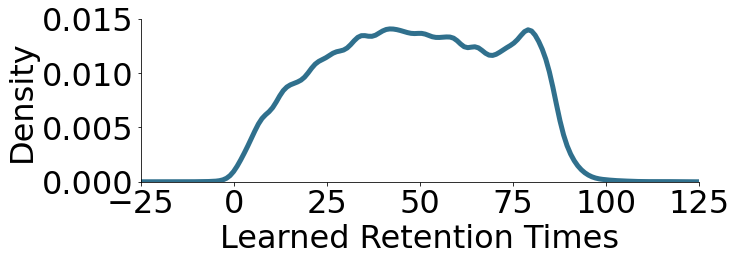

In [3]:
fig = plt.figure(figsize=(10, 3))

sns.kdeplot(peptides.iRT[~peptides.iRT.isna()],
            color="#30708d",
            lw=5)

plt.xlim(-25, 125)
plt.xticks([-25, 0, 25, 50, 75, 100, 125])
plt.yticks([0, 0.005, 0.01, 0.015])
plt.xlabel("Learned Retention Times", size=32)
plt.ylabel("Density", size=32)
plt.tick_params(labelsize=32)

fig.get_axes()[0].spines["right"].set_visible(False)
fig.get_axes()[0].spines["top"].set_visible(False)

plt.savefig("figures/learned_irt_distribution.svg")
plt.show()

#### Errors based on held out detections

In [4]:
peptides_with_error = peptides[~peptides.errorRT.isna()].copy()

In [5]:
peptides_with_error["bin"] = pd.cut(peptides_with_error.iRT,
                                    bins=[-50, 10, 20, 30, 40, 50, 60, 70, 80, 90, 150])

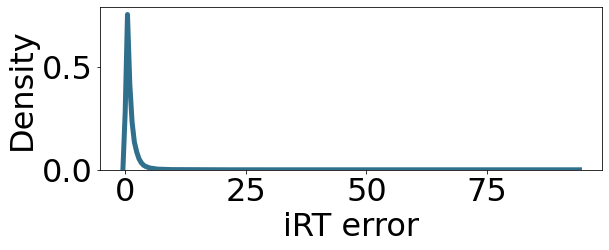

In [6]:
fig = plt.figure(figsize=[9, 3])

sns.kdeplot(peptides_with_error.errorRT,
            color="#30708d",
            lw=5)

#plt.yticks([0, 0.05, 0.1, 0.15])
plt.xlabel("iRT error", size=32)
plt.ylabel("Density", size=32)
plt.tick_params(labelsize=32)

plt.show()

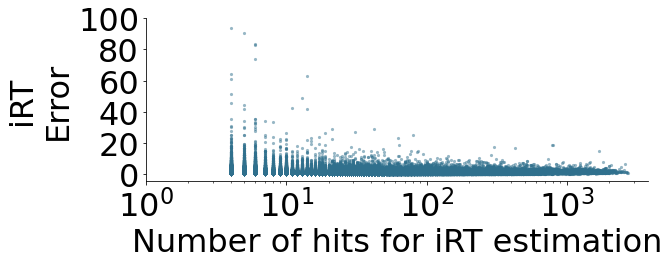

In [7]:
fig = plt.figure(figsize=[9, 3])

sns.scatterplot(data=peptides_with_error,
                x="nRTExamples",
                y="errorRT",
                color="#30708d",
                alpha=.5,
                s=10,
                linewidth=0
                )

plt.xscale("log")
plt.xticks([1e0, 1e1, 1e2, 1e3])
plt.yticks([0, 20, 40, 60, 80, 100])
plt.xlabel("Number of hits for iRT estimation", size=32)
plt.ylabel("iRT\nError", size=32)
plt.tick_params(labelsize=32)
    
fig.get_axes()[0].spines["right"].set_visible(False)
fig.get_axes()[0].spines["top"].set_visible(False)

plt.savefig("figures/number_of_hits_vs_irt_error.png",
            bbox_inches="tight")
plt.savefig("figures/number_of_hits_vs_irt_error.svg")
plt.show()

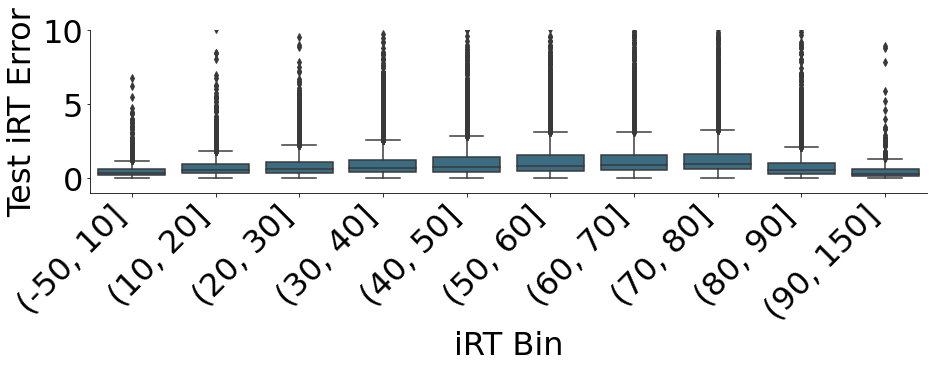

In [8]:
fig = plt.figure(figsize=[15, 3])

sns.boxplot(data=peptides_with_error[peptides_with_error.nRTExamples > 10],
            x="bin",
            y="errorRT",
            color="#30708d"
            )

plt.ylim(-1, 10)
plt.xlabel("iRT Bin", size=32)
plt.ylabel("Test iRT Error", size=32)
plt.xticks(rotation=45, ha='right')
plt.yticks([0, 5, 10])
plt.tick_params(labelsize=32)
    
fig.get_axes()[0].spines["right"].set_visible(False)
fig.get_axes()[0].spines["top"].set_visible(False)

plt.savefig("figures/irt_error_by_irt_bin.svg")
plt.show()

One difficulty that I run into with the above analyses is that the estimate of error is confined to peptides with at least 4 hits. This is an issue since a large portion of the peptides in the database have less than 4 hits. Thus, in the next section I will attempt to derive an error estimate for these peptides which allows us to estimate the error for the whole dataset.

In [9]:
print("Only looking at peptides which have test error excludes {:.2f}% of peptides"
           .format(100*(1-peptides_with_error.shape[0]/peptides.shape[0])))

Only looking at peptides which have test error excludes 49.28% of peptides


## Deriving an iRT predictive error

In [10]:
import os
import requests
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor

if not os.path.exists("sequence_encoder.py"): 
    url = "https://gist.githubusercontent.com/AnthonyOfSeattle/43b932bcb9b5b4b00ccbe96c29769db9/raw/5a1e0d6f3ad35f0a1ba1a9a0a334cd6a7b37e841/sequence_encoder.py"
    r = requests.get(url)
    with open("sequence_encoder.py", "wb") as f:
        f.write(r.content)

from sequence_encoder import SequenceEncoder

In [11]:
def encode_sequences(train_seq, test_seq):
    encoder = SequenceEncoder(pattern="[A-Zn][^A-Zn]*",
                              one_hot=True)
    encoder.fit(np.concatenate([train_seq, test_seq]))
    train_encoded = encoder.fit_transform(train_seq).sum(axis=1)
    test_encoded = encoder.transform(test_seq).sum(axis=1)
    
    return train_encoded, test_encoded

def scale_rts(train_rt, test_rt):
    scaler = StandardScaler()
    train_rt = scaler.fit_transform(train_rt.reshape(-1, 1))
    test_rt = scaler.transform(test_rt.reshape(-1, 1))
    
    return train_rt.flatten(), test_rt.flatten()

def train_rt_model(train_X, train_y):
    model = MLPRegressor(hidden_layer_sizes=[16], 
                         alpha=.1, 
                         max_iter=100,
                         verbose=True)
    model.fit(train_X, train_y)
    
    return model

def score_rt_outliers(sequences, rts, filter_scores=None, filter_quantile=0.5):
    results = pd.DataFrame({"sequences" : np.array(sequences).flatten(),
                            "user_rts" : np.array(rts).flatten()})
    results["scaled_rts"] = 0.
    results["predicted_rts"] = 0.
    results["split_num"] = -1
    for split_num, (train_ind, test_ind) in enumerate(KFold(n_splits=5).split(results)):
        print(f"Training on split {split_num}")
        train_X, test_X = encode_sequences(results.sequences.values[train_ind],
                                           results.sequences.values[test_ind])
        train_y, test_y = scale_rts(results.user_rts.values[train_ind],
                                    results.user_rts.values[test_ind])
        
        if filter_scores is not None:
            train_filter_scores = np.array(filter_scores).flatten()[train_ind]
            is_nan = np.isnan(train_filter_scores)
            filter_cutoff = np.quantile(train_filter_scores[~is_nan],
                                        filter_quantile)
            select = train_filter_scores[~is_nan] < filter_cutoff
            train_X = train_X[~is_nan][select]
            train_y = train_y[~is_nan][select]

        model = train_rt_model(train_X, train_y)
        results.scaled_rts.values[test_ind] = test_y
        results.predicted_rts.values[test_ind] = model.predict(test_X)
        results.split_num.values[test_ind] = split_num
        
    return results

In [12]:
final_data = peptides[~peptides.iRT.isna()].loc[:, ["sequence", "nRTExamples", "iRT", "errorRT"]]

In [13]:
results = score_rt_outliers(final_data.sequence,
                            final_data.iRT,
                            final_data.errorRT)

results["error"] = results.scaled_rts - results.predicted_rts

Training on split 0
Iteration 1, loss = 0.65892043
Iteration 2, loss = 0.12600315
Iteration 3, loss = 0.09127754
Iteration 4, loss = 0.07563062
Iteration 5, loss = 0.06668801
Iteration 6, loss = 0.06070392
Iteration 7, loss = 0.05644350
Iteration 8, loss = 0.05230263
Iteration 9, loss = 0.04898755
Iteration 10, loss = 0.04614946
Iteration 11, loss = 0.04387109
Iteration 12, loss = 0.04189813
Iteration 13, loss = 0.04029325
Iteration 14, loss = 0.03896435
Iteration 15, loss = 0.03775437
Iteration 16, loss = 0.03690379
Iteration 17, loss = 0.03600562
Iteration 18, loss = 0.03529961
Iteration 19, loss = 0.03426268
Iteration 20, loss = 0.03319683
Iteration 21, loss = 0.03264414
Iteration 22, loss = 0.03221436
Iteration 23, loss = 0.03185405
Iteration 24, loss = 0.03156495
Iteration 25, loss = 0.03140765
Iteration 26, loss = 0.03111077
Iteration 27, loss = 0.03099017
Iteration 28, loss = 0.03079304
Iteration 29, loss = 0.03060587
Iteration 30, loss = 0.03058003
Iteration 31, loss = 0.030452

Iteration 18, loss = 0.03788967
Iteration 19, loss = 0.03754908
Iteration 20, loss = 0.03723470
Iteration 21, loss = 0.03693483
Iteration 22, loss = 0.03692394
Iteration 23, loss = 0.03656389
Iteration 24, loss = 0.03635037
Iteration 25, loss = 0.03634694
Iteration 26, loss = 0.03606113
Iteration 27, loss = 0.03598479
Iteration 28, loss = 0.03585441
Iteration 29, loss = 0.03565322
Iteration 30, loss = 0.03569872
Iteration 31, loss = 0.03540039
Iteration 32, loss = 0.03515636
Iteration 33, loss = 0.03463631
Iteration 34, loss = 0.03410833
Iteration 35, loss = 0.03344752
Iteration 36, loss = 0.03283310
Iteration 37, loss = 0.03237506
Iteration 38, loss = 0.03185357
Iteration 39, loss = 0.03158654
Iteration 40, loss = 0.03145287
Iteration 41, loss = 0.03114807
Iteration 42, loss = 0.03094462
Iteration 43, loss = 0.03081310
Iteration 44, loss = 0.03073903
Iteration 45, loss = 0.03071850
Iteration 46, loss = 0.03058579
Iteration 47, loss = 0.03042861
Iteration 48, loss = 0.03047779
Iteratio

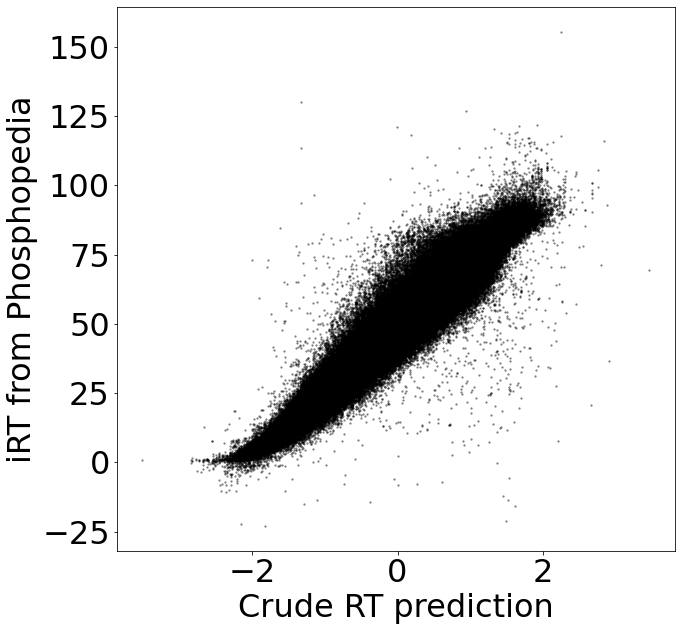

In [14]:
fig = plt.figure(figsize=[10, 10])

sns.scatterplot(data=results,
                x="predicted_rts",
                y="user_rts",
                color="black",
                linewidth=0,
                s=5,
                alpha=.5)

plt.xlabel("Crude RT prediction", size=32)
plt.ylabel("iRT from Phosphopedia", size=32)
plt.tick_params(labelsize=32)

plt.show()

While I see this procedure as very general and applicable with just about any model, the main choice in model here is largely driven by the fact that it is fast and easy to use. If a user specified a deep learning based model, it is likely that they would see a huge increase in effacacy from this technique, and this is something that we have seen in out other applications as well.

[[1.         0.99921315]
 [0.99921315 1.        ]]


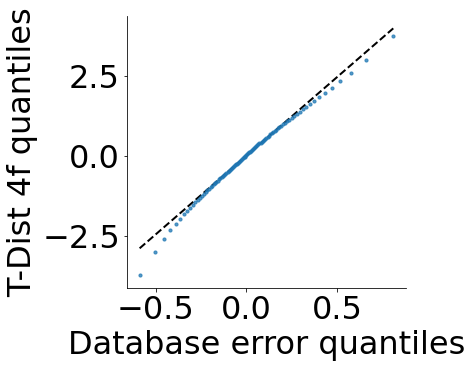

In [15]:
fig = plt.figure(figsize=[5, 5])

df = 4
quantiles = np.linspace(0.01, .99, 99)
result_quantiles = results.error.quantile(quantiles)
theoretical_quantiles = sc.stats.t.ppf(quantiles, df) #sc.stats.norm.ppf(quantiles)
plt.scatter(result_quantiles, 
            theoretical_quantiles,
            s=10,
            alpha=.75)

regression_quantiles = np.linspace(0.1, .9, 51)
x = results.error.quantile(regression_quantiles)
y = sc.stats.t.ppf(regression_quantiles, df)
print(np.corrcoef(x, y))
beta = np.sum((x - np.mean(x))*(y-np.mean(y)))
beta /= np.sum((x - np.mean(x))**2)
alpha = np.mean(y) - beta*np.mean(x)

plt.plot(result_quantiles,
         beta*result_quantiles + alpha,
         c="black",
         lw=2,
         linestyle="dashed",
         zorder=-1)

plt.xlabel("Database error quantiles", size=32)
plt.ylabel("T-Dist %df quantiles" % df, size=32)
plt.tick_params(labelsize=32)

fig.get_axes()[0].spines["right"].set_visible(False)
fig.get_axes()[0].spines["top"].set_visible(False)

plt.savefig("figures/database_rt_error_theoretical_quantiles.svg")
plt.show()

In [16]:
results["scaled_error"] = (results.error - results.error.mean()) * beta

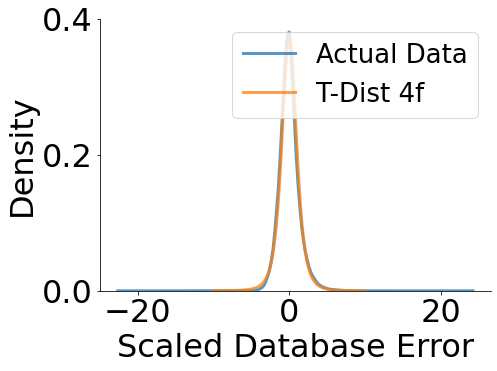

In [17]:
fig = plt.figure(figsize=[7, 5])

sns.kdeplot(results.scaled_error,
            lw=3,
            alpha=.75,
            label="Actual Data")

x = np.linspace(-10, 10, 100)
sns.lineplot(x=x, 
             y=sc.stats.t.pdf(x, df),
             lw=3,
             alpha=.75,
             label="T-Dist %df" % df)

plt.xlabel("Scaled Database Error", size=32)
plt.ylabel("Density", size=32)
plt.tick_params(labelsize=32)
plt.legend(fontsize=26,
           loc="upper right")

fig.get_axes()[0].spines["right"].set_visible(False)
fig.get_axes()[0].spines["top"].set_visible(False)

plt.savefig("figures/scaled_database_rt_error_theoretical_dist.svg",
            bbox_inches="tight")
plt.show()

In [18]:
results["outlier_score"] = -1*np.log10(sc.stats.t.sf(results.scaled_error.abs().values, df))

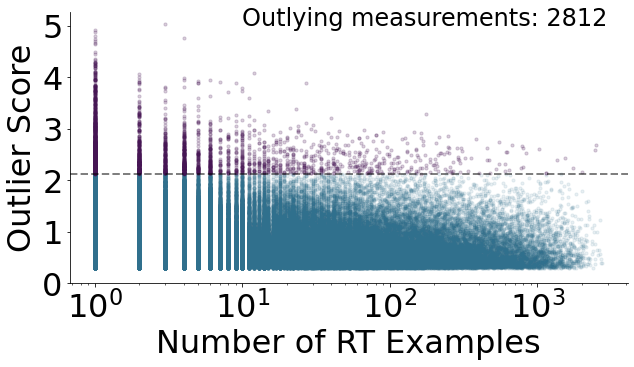

In [19]:
fig = plt.figure(figsize=[10, 5])

# Build scatter
cutoff = sc.stats.t.ppf(.95, df)
outliers = results.outlier_score > cutoff
plt.scatter(x=final_data.nRTExamples.values[~outliers],
            y=results.outlier_score.values[~outliers],
            c="#30708d",
            alpha=.1,
            s=10)
plt.scatter(x=final_data.nRTExamples.values[outliers],
            y=results.outlier_score.values[outliers],
            c="#461554",
            alpha=.2,
            s=10)
plt.axhline(y=cutoff,
            linestyle="dashed",
            c="black",
            alpha=.5,
            lw=2)
plt.text(x=3e3,
         y=5.,
         s="Outlying measurements: {}".format(sum(outliers)),
         size=24,
         ha="right"
         )
plt.xscale("log")
plt.yticks([0, 1, 2, 3, 4, 5])
plt.xlabel("Number of RT Examples", size=32)
plt.ylabel("Outlier Score", size=32)
plt.tick_params(labelsize=32)

fig.get_axes()[0].spines["right"].set_visible(False)
fig.get_axes()[0].spines["top"].set_visible(False)
plt.savefig("figures/database_rt_outlier_score_by_number_of_examples.svg")
plt.show()

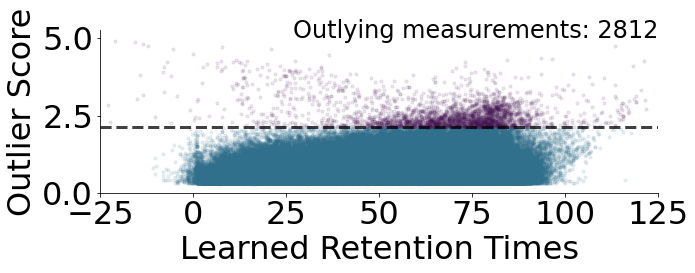

In [20]:
fig = plt.figure(figsize=[10, 3])

# Build scatter
cutoff = sc.stats.t.ppf(.95, df)
outliers = results.outlier_score > cutoff
plt.scatter(x=results.user_rts.values[~outliers], 
            y=results.outlier_score.values[~outliers],
            color="#30708d",
            alpha=.1,
            s=10)
plt.scatter(x=results.user_rts.values[outliers], 
            y=results.outlier_score.values[outliers],
            color="#461554",
            alpha=.1,
            s=10)
plt.axhline(y=cutoff,
            linestyle="dashed",
            c="black",
            alpha=.75,
            lw=3)
plt.text(x=125,
         y=5.,
         s="Outlying measurements: {}".format(sum(outliers)),
         size=24,
         ha="right"
         )

plt.xlim(-25, 125)
plt.xticks([-25, 0, 25, 50, 75, 100, 125])
plt.yticks([0, 2.5, 5.0])
plt.xlabel("Learned Retention Times", size=32)
plt.ylabel("Outlier Score", size=32)
plt.tick_params(labelsize=32)

fig.get_axes()[0].spines["right"].set_visible(False)
fig.get_axes()[0].spines["top"].set_visible(False)
plt.savefig("figures/database_rt_outlier_score_by_rt.svg")
plt.show()

I think in many ways this metric could be quite useful to a user of Phoshopedia. In the case that a user wants to target a peptide, but that peptide has a large outlier score, there is every reason for the user to expect that substituting that RT for a predicted value would be a much better idea. Therefore, we will likely incorporate this score into Phosphopedia so that users can benefit.